## Ejercicio 1

En este problema, se presenta un conjunto de datos que contiene información sobre el rendimiento académico de estudiantes universitarios, así como diversos factores que podrían influir en él. El objetivo es construir un modelo de regresión utilizando redes neuronales para predecir el índice de rendimiento académico de los estudiantes basado en las características proporcionadas.

### Comenzamos con el codigo

Importamos dependencias a utilizar en la resolucion del problema. Las mismas se encuentra especificadas en el documento ".txt" llamado "requirements.txt"

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf


In [5]:
import os

print(os.getcwd())

c:\Users\augus\Desktop\FCEIA\TUIA\5to_cuatrimestre\Aprendizaje II\TP1-AA2-Lorenzetti_Farias_Garcia\TP1-1


Importamos nuestra base de datos, la que vamos a utilizar para la resolución del enunciado.
Para esto utilizamos Pandas y nos creamos un DataFrame

In [67]:
df = pd.read_csv('src/dataset/Student_Performance.csv')

df

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0


Una vez cargado nuestro DataFrame, comenzamos con el análisis exploratorio de los datos, donde vamos a analizar las columnas, que tipo de datos poseen, si poseen valores faltantes o nulos, si hay correlacion entre las variables y tambien analizaremos graficamente el dataset para asi poder detectar tendencias o patrones en los datos.

In [7]:
df.columns

Index(['Hours Studied', 'Previous Scores', 'Extracurricular Activities',
       'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [9]:
df.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [10]:
vacios_original=df.isna().sum()
vacios_original

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

Para mayor practicidad a la hora de graficar y analizar nuestros datos visualmente, vamos a crearnos funciones que contengan todo el codigo encargado de esto.

In [11]:
def plot_variables(df):
    sns.set(style="darkgrid")

    # Obtiene una lista de todas las columnas numéricas del DataFrame
    numeric_columns = df.select_dtypes(include=[float, int]).columns

    # Calcula el número de filas y columnas necesarias para el ploteo
    num_rows = (len(numeric_columns) + 1) // 2
    num_cols = 2

    # Establece un tamaño de figura común
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20,10))

    # Espacio entre los subplots
    plt.subplots_adjust(wspace=1, hspace=1)

    # Colores distintos para los histogramas
    colors = sns.color_palette("Set2", n_colors=len(numeric_columns))

    # Itera a través de las columnas numéricas y crea un histograma para cada una
    for i, col in enumerate(numeric_columns):
        row = i // num_cols
        col_idx = i % num_cols

        # Selecciona un color diferente para cada histograma
        color = colors[i]

        sns.histplot(data=df, x=col, kde=True, color=color, ax=axs[row, col_idx])

        axs[row, col_idx].set_xlabel(col, fontsize=12)
        axs[row, col_idx].set_ylabel("Count",fontsize=12)

        # Cambia el tamaño de letra de los ejes X y Y
        axs[row, col_idx].tick_params(axis='x', labelsize=12)
        axs[row, col_idx].tick_params(axis='y', labelsize=12)

    # Elimina cualquier subplot no utilizado
    for i in range(len(numeric_columns), num_rows * num_cols):
        row = i // num_cols
        col_idx = i % num_cols
        fig.delaxes(axs[row, col_idx])

    
    fig.suptitle(f"Histogramas de variables numéricas", fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta el espacio para el título general
    plt.show()

def matriz_correlacion(df):
    corr = df.select_dtypes(include=[float, int]).corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(20, 10))  # Tamaño de figura ajustado
    ax = sns.heatmap(
        corr,
        #mask = mask,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        annot=True,
        annot_kws={'size': 10},  # Tamaño de las anotaciones ajustado
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

    # Añade un título general a la figura
    ax.set_title("Matriz de Correlación", fontsize=12)
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta el espacio para el título general
    plt.show()

def global_boxplots(df):
    # Asegúrate de que todas las columnas sean numéricas
    columnas_numericas = df.select_dtypes(include=['number'])
    
    if columnas_numericas.empty:
        print("No hay columnas numéricas en el DataFrame.")
        return
    
    # Normalizar las columnas numéricas
    scaler = StandardScaler()
    columnas_numericas_normalized = pd.DataFrame(scaler.fit_transform(columnas_numericas), columns=columnas_numericas.columns)
    
    # Crear una lista de títulos de columnas rotados
    column_titles = [col for col in columnas_numericas_normalized.columns]
    
    # Graficar los boxplots de las columnas numéricas normalizadas con rango en el eje Y de -4 a 4
    plt.figure(figsize=(20, 10))  # Tamaño de figura ajustado
    plt.title("Boxplots para todas las variables")
    boxplot = plt.boxplot(columnas_numericas_normalized.values, vert=True)
    
    # Rotar los títulos de las columnas
    plt.xticks(range(1, len(columnas_numericas_normalized.columns) + 1), column_titles, rotation=90)
    
    plt.xlabel("Variables")
    plt.ylabel("Valores Normalizados")
    plt.ylim(-4, 4)  # Establecer el rango en el eje Y
    plt.show()


def scatter_plot(df):
    numeric_cols = df.select_dtypes(include=['number'])
    num_plots = len(numeric_cols.columns)
    
    # Determina el número de filas y columnas para la matriz
    num_rows = (num_plots + 2) // 3  # Redondea hacia arriba
    num_cols = min(num_plots, 3)

    # Aumenta el tamaño de la figura
    figsize = (20,10)  # Aumenta la altura de la figura
    
    # Crea una figura de Matplotlib con subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    for i, col in enumerate(numeric_cols.columns):
        row = i // num_cols
        col_num = i % num_cols  # Cambia el nombre de la variable para evitar la confusión

        # Selecciona el subplot actual
        ax = axes[row, col_num]

        # Crea el gráfico de dispersión en el subplot
        sns.scatterplot(x=col, y='Performance Index', data=df, ax=ax)
        ax.set_title(col)  # Configura el título del subplot

    # Elimina subplots no utilizados
    for i in range(num_plots, num_rows * num_cols):
        row = i // num_cols
        col_num = i % num_cols
        fig.delaxes(axes[row, col_num])

    plt.tight_layout()
    plt.show()

    
def graficos(df):
    # Imprimir la cantidad de datos disponibles
    print(f"Cantidad de datos disponibles en el DataFrame: {len(df)}")
    plot_variables(df)
    matriz_correlacion(df)
    global_boxplots(df)
    scatter_plot(df)

Cantidad de datos disponibles en el DataFrame: 10000


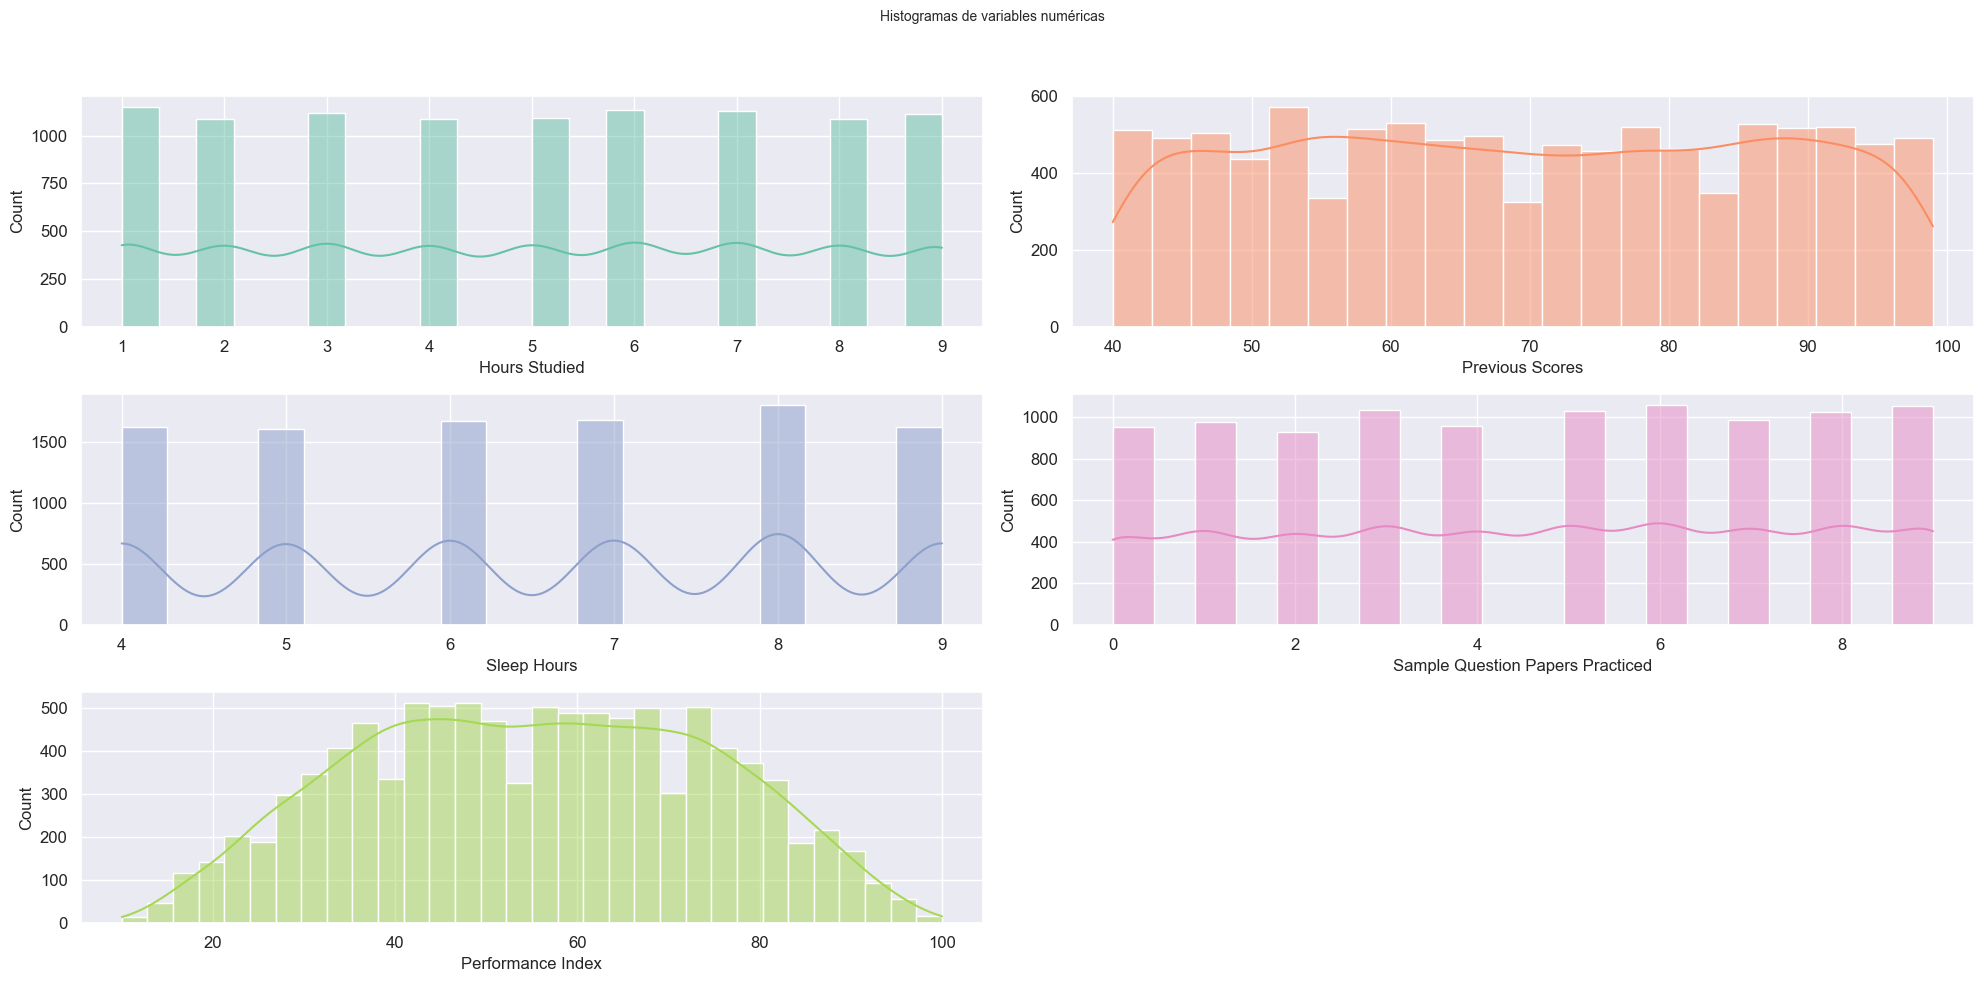

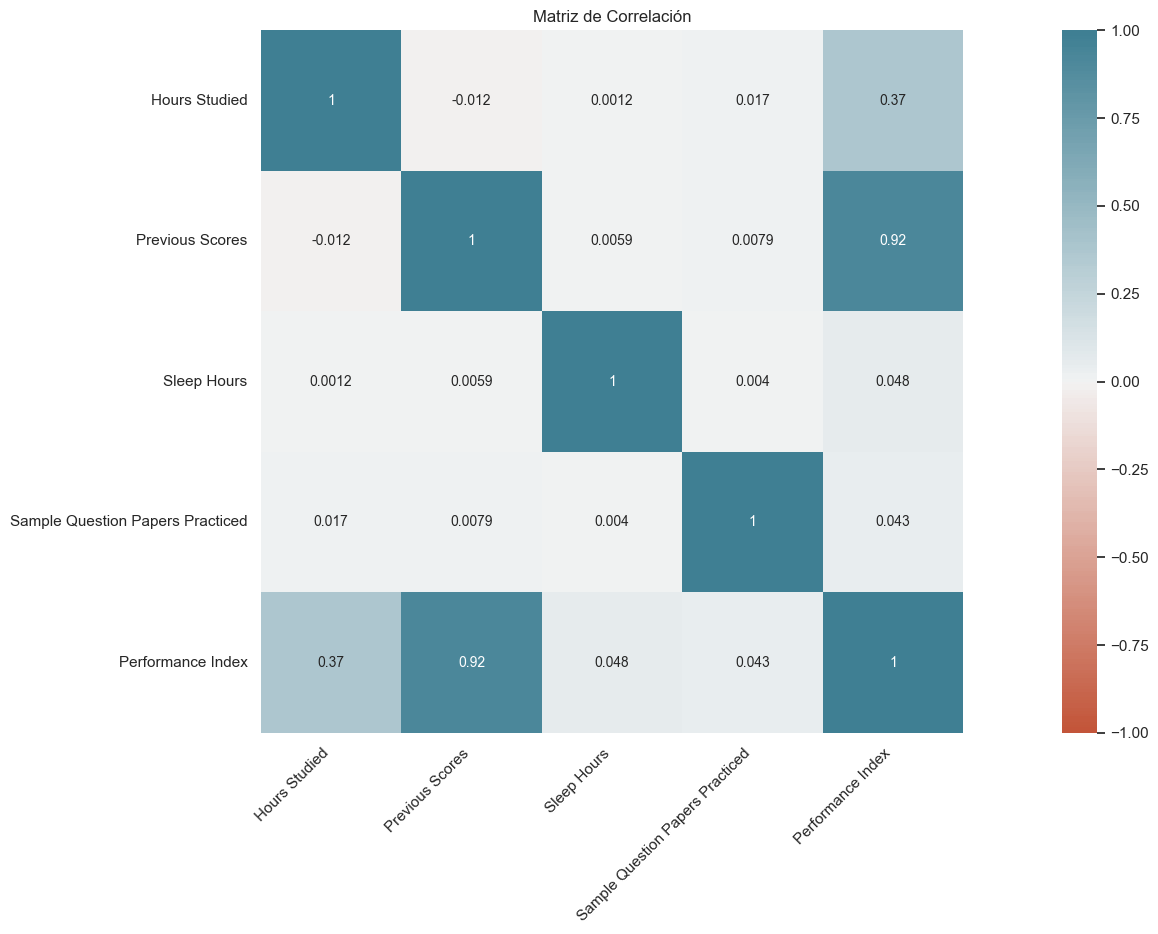

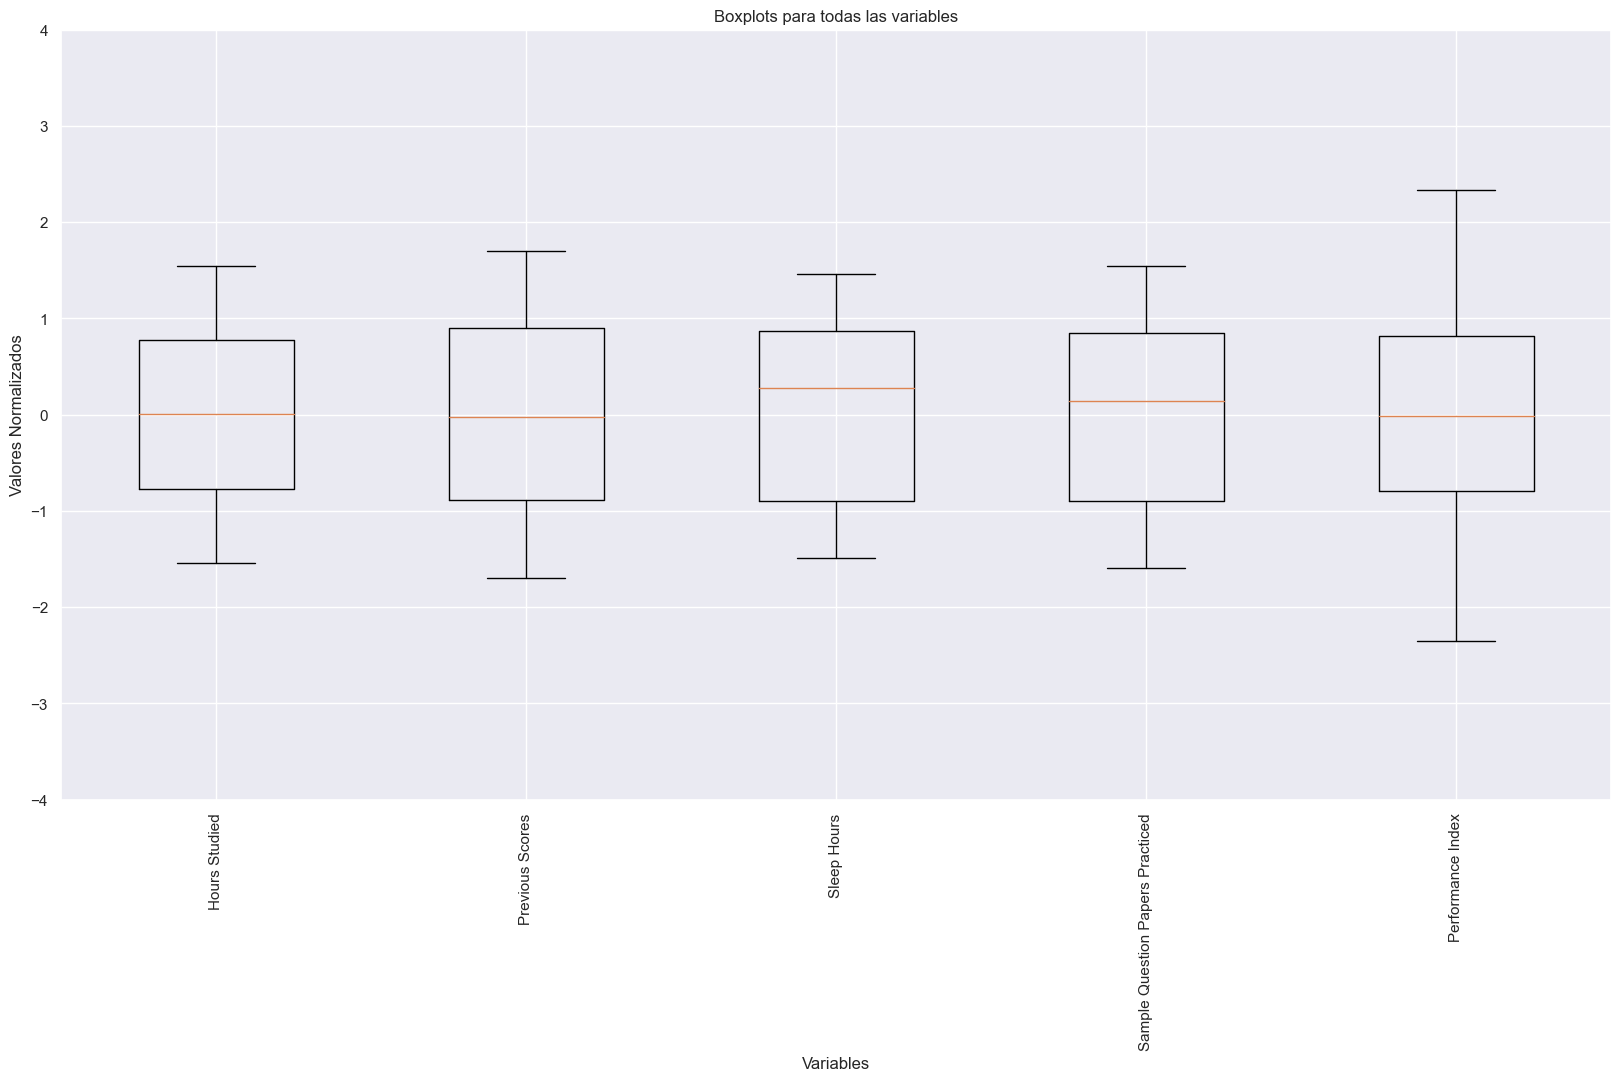

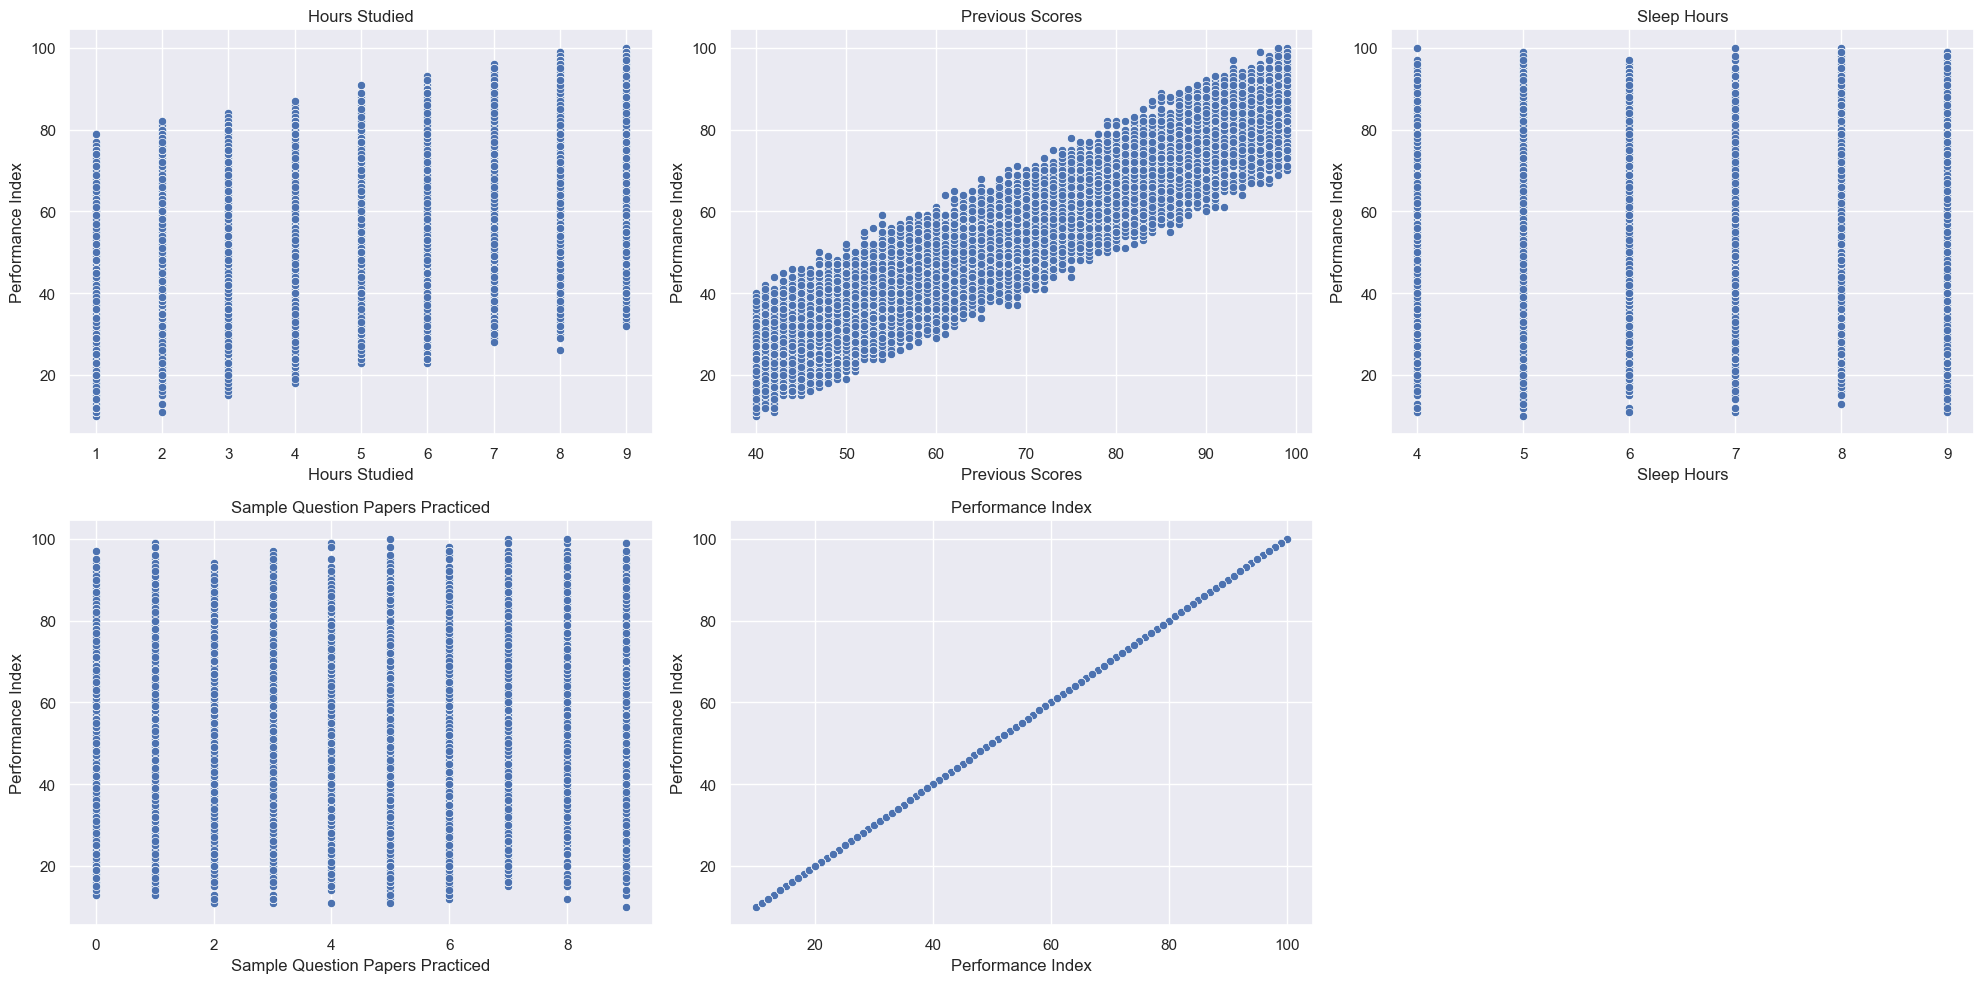

In [12]:
graficos(df)

Tambien chequeamos que las clases de nuestra variable objetivo, esten balanceadas

In [13]:
def check_balance(df):
    """
    Calcula el balance de clases para las columnas objetivo en un DataFrame.
    """
    
    intervalos = [(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 70), (70, 80), (80, 90), (90, 100)]

    total_valores = len(df['Performance Index'])

    conteos = {}
    for intervalo in intervalos:
        inicio, fin = intervalo
        conteo = ((df['Performance Index'] >= inicio) & (df['Performance Index'] <= fin)).sum()
        conteos[intervalo] = conteo

    balance = {intervalo: (conteo / total_valores) * 100 for intervalo, conteo in conteos.items()}

    # Crear un DataFrame para el gráfico
    nombres_intervalos = [f"({inicio}-{fin})" for inicio, fin in intervalos]
    data = pd.DataFrame({'Intervalo': nombres_intervalos, 'Balance': list(balance.values())})

    # Crear el gráfico de barras utilizando Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Intervalo', y='Balance', data=data, color='skyblue')
    plt.title('Balance de la columna "Performance Index"')
    plt.xlabel('Intervalo')
    plt.ylabel('Porcentaje de valores')

    # Mostrar los porcentajes en las barras
    for index, value in enumerate(balance.values()):
        plt.text(index, value + 1, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)

    plt.xticks(rotation=45)  # Rotar los nombres de los intervalos para mejor legibilidad
    plt.ylim(0, 100)  # Establecer el rango del eje y de 0 a 100
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Agregar una cuadrícula en el eje y
    plt.tight_layout()  # Ajustar el diseño para evitar superposiciones
    plt.show()

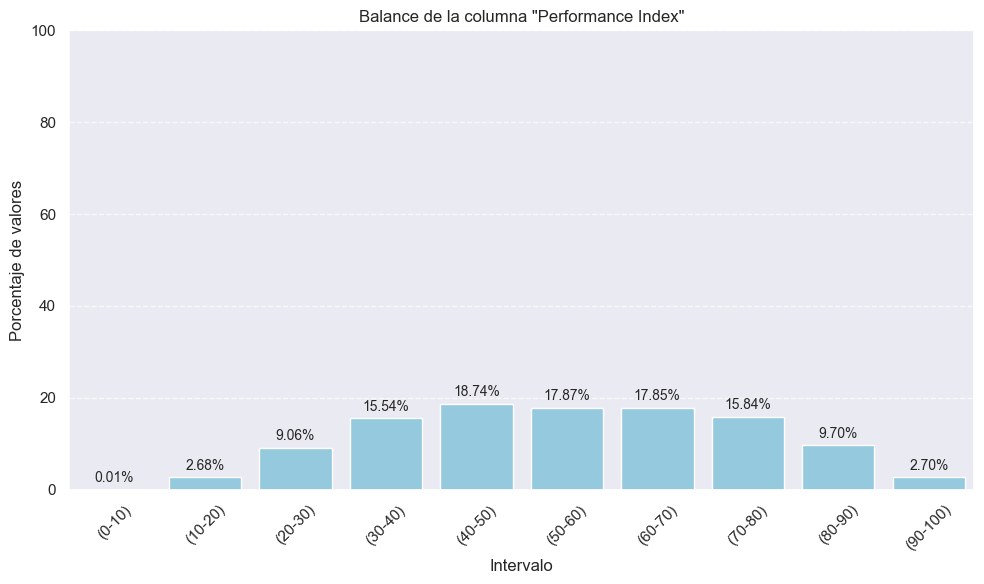

In [14]:
check_balance(df)

Aca podemos ver que la distribucion de los datos de Performance de los alumnos se asemejan a una Normal.

CREAMOS NUESTRO MODELO

Vamos a crear un modelo secuencial con Keras, que constara de:
Una capa de entrada que espera 5 características.
Una capa oculta con 3 neuronas y función de activación sigmoida.
Y una capa de salida con 1 neurona y función de activación lineal. 
Ya que nuestra salida esperada es predecir el desempeño de los estudiantes que es un valor numerico.

Luego entrenamos el modelo con los datos de entrenamiento escalados. Durante 20 épocas. Con un tamaño de lote de 32, y usaremos el 20% de los datos de entrenamiento para validación.

In [98]:
def modelo(df):
    """
    Red neuronal de regresión para predecir el rendimiento de los estudiantes.
    """
    # Convertir "Yes" a 1 y "No" a 0
    df['Extracurricular Activities'] = df['Extracurricular Activities'].map({'Yes': 1, 'No': 0})

    X = df.iloc[:, :5].values
    y = df['Performance Index'].values

    # Dividir los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Escalar características numéricas
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

    #model = tf.keras.Sequential([
    #tf.keras.layers.Input(shape=(5,)),
    #tf.keras.layers.Dense(units=3, activation = 'sigmoid'),
    #tf.keras.layers.Dense(units=1, activation='linear')])
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(5,)),
        tf.keras.layers.Dense(units=8, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=4, activation='sigmoid'),
        tf.keras.layers.Dense(units=1, activation='linear')])


    model.compile(optimizer=optimizer, loss='mse', metrics= ['accuracy'])
    
    history = model.fit(X_train_scaled, y_train, epochs=30, batch_size=16, validation_split= 0.2)


    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

        
    # Evaluar el modelo en los datos de prueba
    loss = model.evaluate(X_test_scaled, y_test)

    print("Pérdida en los datos de prueba:", loss)
        # Seleccionar una instancia de ejemplo del conjunto de prueba
    ejemplo_idx = 4  # Índice de la instancia de ejemplo que deseas probar
    X_ejemplo = X_test[ejemplo_idx]  # Características del ejemplo seleccionado
    y_true = y_test[ejemplo_idx]  # Etiqueta verdadera del ejemplo seleccionado

    # Realizar una predicción con el modelo
    y_pred = model.predict(X_ejemplo.reshape(1, -1))  # La entrada debe tener forma (1, num_caracteristicas)

    print("Características del ejemplo:", X_ejemplo)
    print("Etiqueta verdadera del ejemplo:", y_true)
    print("Predicción del modelo:", y_pred[0, 0])

Epoch 1/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0000e+00 - loss: 1843.6002 - val_accuracy: 0.0000e+00 - val_loss: 145.1182
Epoch 2/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 96.3958 - val_accuracy: 0.0000e+00 - val_loss: 28.7018
Epoch 3/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 31.1143 - val_accuracy: 0.0000e+00 - val_loss: 14.0446
Epoch 4/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 19.6649 - val_accuracy: 0.0000e+00 - val_loss: 11.3304
Epoch 5/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 20.1268 - val_accuracy: 0.0000e+00 - val_loss: 11.4325
Epoch 6/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 17.2359 - val_accuracy: 0.0000e+00 - val_loss: 10.1905
Epoch 7/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 18.7447 - val_accuracy: 0.0000e+00 - val_loss: 8.8726
Epoch 8/30
400/400 ━━━━━━━━━━━━━

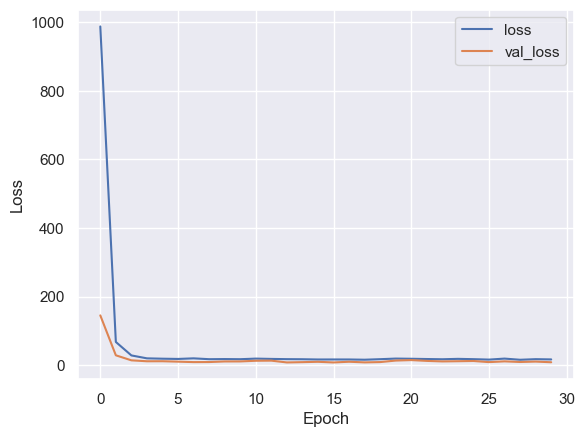

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 9.6693
Pérdida en los datos de prueba: [9.1901273727417, 0.0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Características del ejemplo: [ 7 53  0  4  6]
Etiqueta verdadera del ejemplo: 41.0
Predicción del modelo: 88.79574


In [100]:
modelo(df)